# <font color='red'> Car accident prediction

The aim of this notebook is to predict whether clients of an insurance company were involved in a car crash, using their personal folders and service records. We will implement classification algorithms after an appropriate processing of the data.

## <font color='grey'> Importing libraries

In [149]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import collections

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier


# Data Processing Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

## <font color='grey'> Loading training and test tests

In [150]:
df_train = pd.read_csv('C:\\Users\\Hadamard\\Downloads\\Test technique Descartes Underwriting\\train_auto.csv')
df_test = pd.read_csv('C:\\Users\\Hadamard\\Downloads\\Test technique Descartes Underwriting\\test_auto.csv')

In [151]:
pd.set_option('display.max_columns', None)

In [152]:
df_train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


###   We have 3 types of variables :


* **Numerical** : TARGET_FLAG (to predict), TARGET_AMT (another variable to predict : the cost of the accident), KIDSDRIV, AGE, HOMEKIDS, YOJ, INCOME, PARENT1, HOME_VAL, TRAVTIME, BLEUBOOK, TIF, OLDCLAIM, CLM_FREQ, MVR_PTS, CAR_AGE
* **Binary** : SEX, PARENT1, MSTATUS, CAR_USE, RED_CAR, REVOKED, URBANICITY
* **Categorical** : EDUCATION, JOB, CAR_TYPE
    
    

##  <font color='grey'> Distribution of the target variable (TARGET_FLAG) indiquant si un accident s'est produit

<AxesSubplot:>

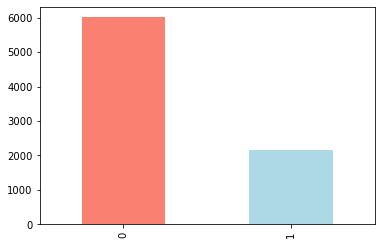

In [153]:
df_train['TARGET_FLAG'].value_counts().plot(kind="bar", color=["salmon", "lightblue"])

#### Roughly 3 quarters of the train set (~74%) of the training set is associated with an accident : the imbalance is relatively mild. Therefore, in the first instance, we will not treat this problem with the usual imbalanced data classification tools (such as oversampling and undersampling).

##  <font color='grey'> Some statistics for the training and test sets

In [154]:
df_train.describe()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,5151.867663,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,33.485725,5.351305,0.798554,1.695503,8.328323
std,2978.893962,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,15.908333,4.146635,1.158453,2.147112,5.700742
min,1.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000
25%,2559.000000,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,5133.000000,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,7745.000000,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000
max,10302.000000,1.000000,107586.136200,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000


#### I spotted a negative value for CAR_AGE (-3) : clearly an outlier. Nevertheless it is the only strictly negative value in the training set (I haven't processed yet the amount variables)

In [155]:
sum(n < 0 for n in df_train.select_dtypes(include=['float64','int64']).values.flatten())

1

In [156]:
df_test.drop(columns=['TARGET_FLAG','TARGET_AMT'],axis=1,inplace=True)

In [157]:
df_test.describe()

,INDEX,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
count,2141.000000,2141.000000,2140.000000,2141.000000,2047.000000,2141.000000,2141.000000,2141.000000,2141.000000,2012.000000
mean,5150.098552,0.162541,45.016822,0.717422,10.379091,33.152265,5.244745,0.808968,1.765997,8.183400
std,2956.329272,0.486949,8.525006,1.116579,4.170008,15.722393,3.971026,1.137481,2.203413,5.766263
min,3.000000,0.000000,17.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000
25%,2632.000000,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000
50%,5224.000000,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000
75%,7669.000000,0.000000,51.000000,1.000000,13.000000,43.000000,7.000000,2.000000,3.000000,12.000000
max,10300.000000,3.000000,73.000000,5.000000,19.000000,105.000000,25.000000,5.000000,12.000000,26.000000


#### We notice that the numerical variables in the training and test sets have a similar distribution, which is reassuring

#### As you can imagine, the "Index" variable is irrelevant and we can remove it

In [158]:
df_train.drop(columns='INDEX',inplace=True)

#### We have to turn the amount variables (dollars) into numbers : let's write a small function for this extraction

In [159]:
df_train['INCOME'].values[0] # The format of an amount

'$67,349 '

In [160]:
import re
def income_process(income):
    string = str(income)
    string = string[1:-1]
    numbers = string.replace(",","")
    return(numbers)

In [161]:
income_process('$67,349 ')

'67349'

#### Now we can apply our function to all the columns concerned

In [162]:
df_train['INCOME'] = df_train['INCOME'].apply(income_process)
df_train["INCOME"] = pd.to_numeric(df_train["INCOME"],errors='coerce')

In [163]:
df_train['HOME_VAL'] = df_train['HOME_VAL'].apply(income_process)
df_train['HOME_VAL'] = pd.to_numeric(df_train['HOME_VAL'],errors='coerce')

In [164]:
df_train['OLDCLAIM'] = df_train['OLDCLAIM'].apply(income_process)
df_train['OLDCLAIM'] = pd.to_numeric(df_train['OLDCLAIM'],errors='coerce')

In [165]:
df_train['BLUEBOOK'] = df_train['BLUEBOOK'].apply(income_process)
df_train['BLUEBOOK'] = pd.to_numeric(df_train['BLUEBOOK'],errors='coerce')

#### Let's plot histograms for all the numerical data : the variables that come closest to a normal distribution are Age and YOJ

array([[<AxesSubplot:title={'center':'TARGET_FLAG'}>,
        <AxesSubplot:title={'center':'TARGET_AMT'}>,
        <AxesSubplot:title={'center':'KIDSDRIV'}>,
        <AxesSubplot:title={'center':'AGE'}>],
       [<AxesSubplot:title={'center':'HOMEKIDS'}>,
        <AxesSubplot:title={'center':'YOJ'}>,
        <AxesSubplot:title={'center':'INCOME'}>,
        <AxesSubplot:title={'center':'HOME_VAL'}>],
       [<AxesSubplot:title={'center':'TRAVTIME'}>,
        <AxesSubplot:title={'center':'BLUEBOOK'}>,
        <AxesSubplot:title={'center':'TIF'}>,
        <AxesSubplot:title={'center':'OLDCLAIM'}>],
       [<AxesSubplot:title={'center':'CLM_FREQ'}>,
        <AxesSubplot:title={'center':'MVR_PTS'}>,
        <AxesSubplot:title={'center':'CAR_AGE'}>, <AxesSubplot:>]],
      dtype=object)

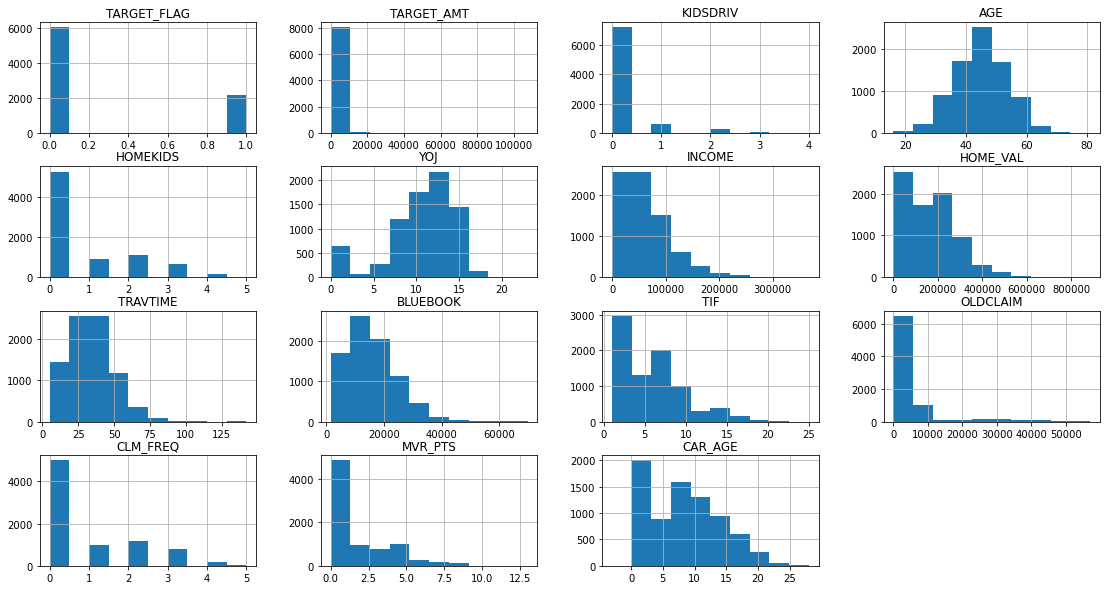

In [166]:
df_train.hist(figsize=(19,10),bins=10)

In [167]:
df_train.describe()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,61898.094609,154867.289723,33.485725,15709.899522,5.351305,4037.076216,0.798554,1.695503,8.328323
std,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,47572.682808,129123.774574,15.908333,8419.734075,4.146635,8777.139104,1.158453,2.147112,5.700742
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,28097.000000,0.000000,22.000000,9280.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,54028.000000,161160.000000,33.000000,14440.000000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,85986.000000,238724.000000,44.000000,20850.000000,7.000000,4636.000000,2.000000,3.000000,12.000000
max,1.000000,107586.136200,4.000000,81.000000,5.000000,23.000000,367030.000000,885282.000000,142.000000,69740.000000,25.000000,57037.000000,5.000000,13.000000,28.000000


#### Only binary/categorical variables remain :

In [168]:
df_train.dtypes

TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME         float64
PARENT1         object
HOME_VAL       float64
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK         int64
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM         int64
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object

In [169]:
from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()

# get numeric data
# num_d = df_train.select_dtypes(exclude=['object'])

# update the cols with their normalized values
# df_train[num_d.columns] = sc.fit_transform(num_d)

## <font color='grey'> Data exploration

### NaN values proportion for each column (in descending order) : 

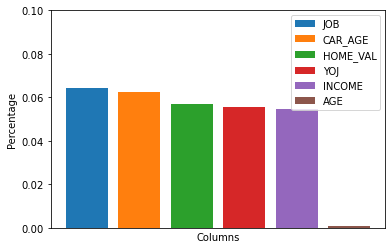

In [170]:
plot = df_train.isnull().mean().sort_values(ascending=False)
f, ax = plt.subplots()

for i,item in enumerate(zip(plot.keys(),plot.values)):
    if (item[1] > 0):
        ax.bar(item[0], item[1], label = item[0])

ax.set_xticklabels([]) 
ax.set_xticks([]) 
plt.ylim(0,0.1)
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.legend()
plt.show()

### Patterns in data completion ?

<AxesSubplot:>

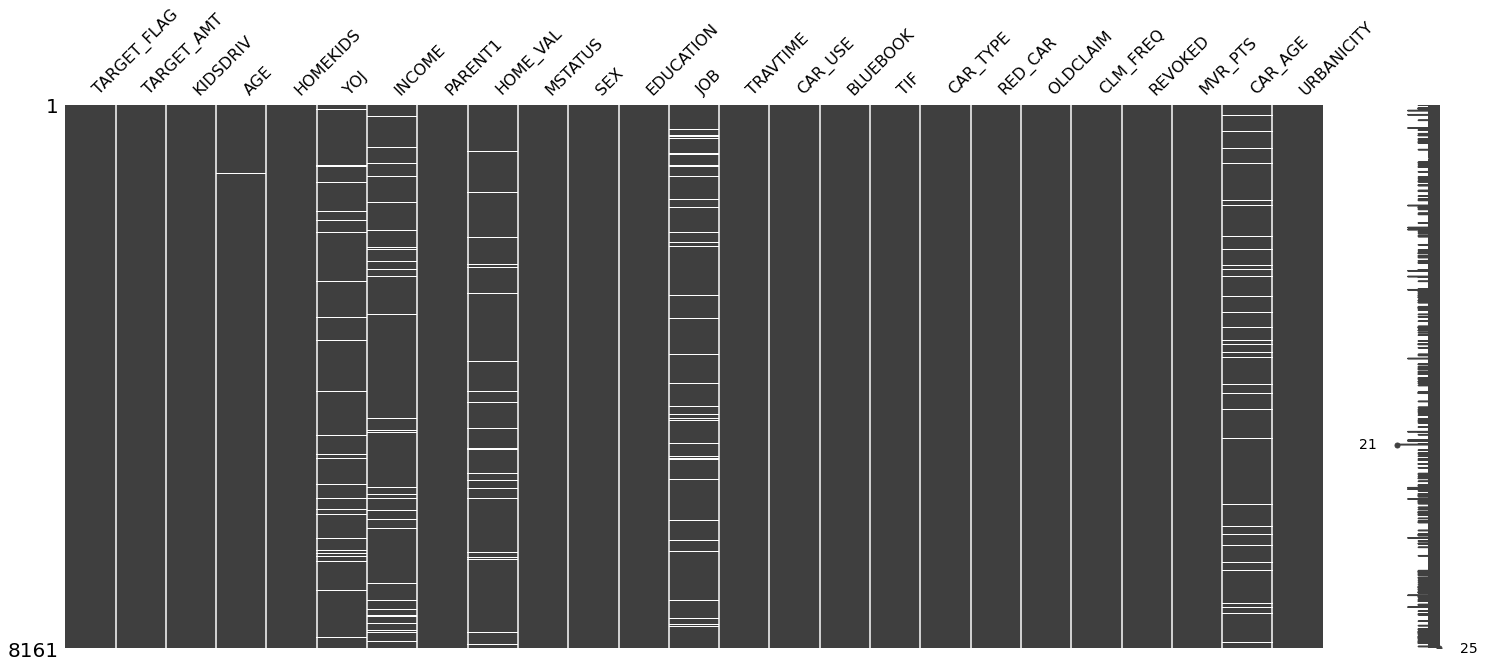

In [171]:
import missingno as msno
msno.matrix(df_train)

#### Correlation heatmap to see if there is any correlation between missing values in different columns

<AxesSubplot:>

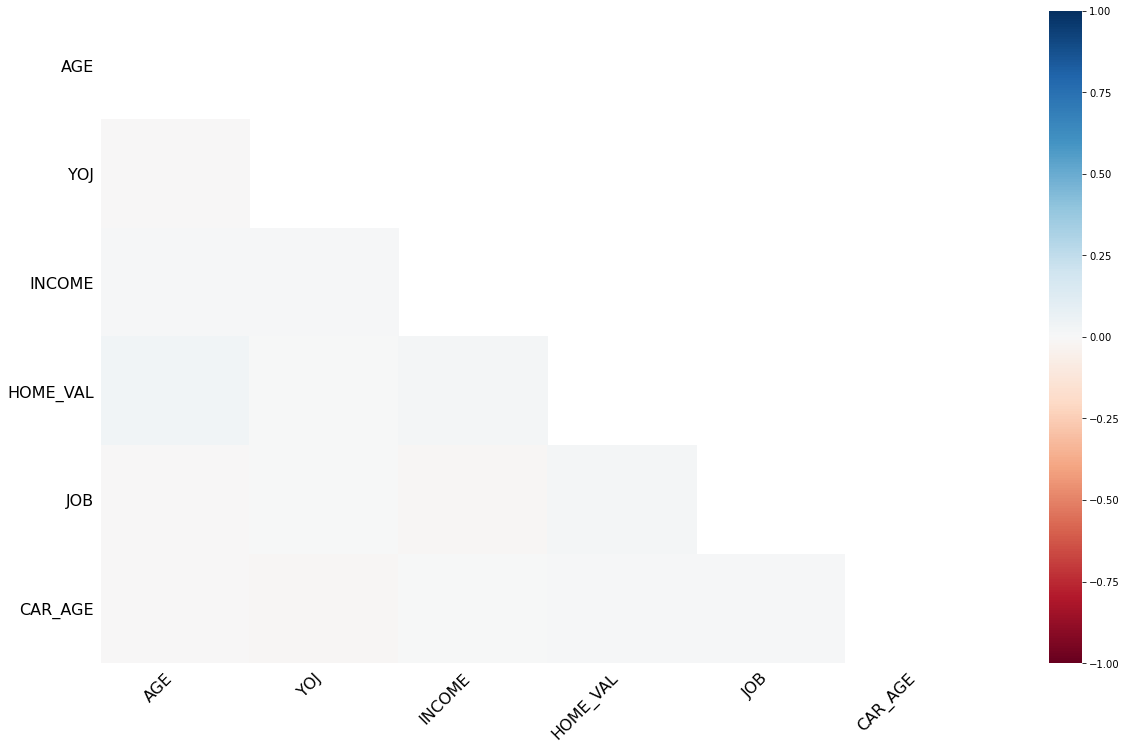

In [172]:
msno.heatmap(df_train)

#### We can confirm that the NaN values are uncorrelated. Let's see if the data should be cleaned before imputing missing values and processing binary/categorical columns

In [173]:
df_train['EDUCATION'].value_counts()

z_High School    2330
Bachelors        2242
Masters          1658
<High School     1203
PhD               728
Name: EDUCATION, dtype: int64

In [174]:
df_train['SEX'].value_counts()

z_F    4375
M      3786
Name: SEX, dtype: int64

#### I'm guessing that the z_ at the beginning is a typo, looking at the columns "Sex" and "Education", and thus we can assume that < High School means an academic level below high school

#### Let's display the values that are taken by each variable and their counts :

In [175]:
for y in df_train.columns:
    if(df_train[y].dtype == object):
          print(df_train[y].value_counts())

No     7084
Yes    1077
Name: PARENT1, dtype: int64
Yes     4894
z_No    3267
Name: MSTATUS, dtype: int64
z_F    4375
M      3786
Name: SEX, dtype: int64
z_High School    2330
Bachelors        2242
Masters          1658
<High School     1203
PhD               728
Name: EDUCATION, dtype: int64
z_Blue Collar    1825
Clerical         1271
Professional     1117
Manager           988
Lawyer            835
Student           712
Home Maker        641
Doctor            246
Name: JOB, dtype: int64
Private       5132
Commercial    3029
Name: CAR_USE, dtype: int64
z_SUV          2294
Minivan        2145
Pickup         1389
Sports Car      907
Van             750
Panel Truck     676
Name: CAR_TYPE, dtype: int64
no     5783
yes    2378
Name: RED_CAR, dtype: int64
No     7161
Yes    1000
Name: REVOKED, dtype: int64
Highly Urban/ Urban      6492
z_Highly Rural/ Rural    1669
Name: URBANICITY, dtype: int64


#### Among the columns with missing values, only Job is categorical

In [176]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   float64
 7   PARENT1      8161 non-null   object 
 8   HOME_VAL     7697 non-null   float64
 9   MSTATUS      8161 non-null   object 
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   int64  
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   object 
 19  OLDCLA

In [177]:
#df_train[df_train['JOB'].isnull()] = 'NaN'

In [178]:
df_train['JOB'].values[:50]

array(['Professional', 'z_Blue Collar', 'Clerical', 'z_Blue Collar',
       'Doctor', 'z_Blue Collar', 'z_Blue Collar', 'z_Blue Collar',
       'Clerical', 'Professional', 'Lawyer', 'Professional', 'Manager',
       nan, 'Home Maker', 'Clerical', 'Lawyer', 'Lawyer', 'Clerical',
       'z_Blue Collar', 'z_Blue Collar', 'Lawyer', 'z_Blue Collar',
       'Home Maker', 'Professional', 'Clerical', 'Manager', 'Clerical',
       'Home Maker', 'Clerical', 'Professional', nan, 'z_Blue Collar',
       'Home Maker', 'Doctor', 'Clerical', nan, 'Doctor', 'Student',
       'Student', 'Manager', 'Clerical', 'Clerical', 'Student', 'Student',
       'Professional', 'Clerical', 'Clerical', 'Lawyer', 'z_Blue Collar'],
      dtype=object)

#### We will map categorical columns with ordinal encoding because most of them have an inherent order (like the Education column)

In [179]:
df_train['JOB'] = df_train['JOB'].map({'z_Blue Collar': 0, 'Home Maker': 1, 'Student': 2, 'Professional': 3, 'Manager' : 4, 'Clerical' : 5,  'Doctor': 6, 'Lawyer' : 7})
df_train['JOB'] = pd.to_numeric(df_train['JOB'],errors='coerce')

In [180]:
df_train['JOB']

0       3.0
1       0.0
2       5.0
3       0.0
4       6.0
       ... 
8156    0.0
8157    4.0
8158    NaN
8159    1.0
8160    5.0
Name: JOB, Length: 8161, dtype: float64

In [181]:
from sklearn.preprocessing import OrdinalEncoder

#df_train.fillna(-1,inplace=True)

enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
df_train[['SEX', 'PARENT1', 'MSTATUS', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY',
'EDUCATION', 'CAR_TYPE']] = enc.fit_transform(df_train[['SEX', 'PARENT1', 'MSTATUS', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY', 'EDUCATION', 'CAR_TYPE']])

In [182]:
df_train.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0.0,0,60.0,0,11.0,67349.0,0.0,0.0,1.0,0.0,3.0,3.0,14,1.0,14230,11,0.0,1.0,4461,2,0.0,3,18.0,0.0
1,0,0.0,0,43.0,0,11.0,91449.0,0.0,257252.0,1.0,0.0,4.0,0.0,22,0.0,14940,1,0.0,1.0,0,0,0.0,0,1.0,0.0
2,0,0.0,0,35.0,1,10.0,16039.0,0.0,124191.0,0.0,1.0,4.0,5.0,5,1.0,4010,4,5.0,0.0,38690,2,0.0,3,10.0,0.0
3,0,0.0,0,51.0,0,14.0,NaN,0.0,306251.0,0.0,0.0,0.0,0.0,32,1.0,15440,7,0.0,1.0,0,0,0.0,0,6.0,0.0
4,0,0.0,0,50.0,0,NaN,114986.0,0.0,243925.0,0.0,1.0,3.0,6.0,36,1.0,18000,1,5.0,0.0,19217,2,1.0,3,17.0,0.0


#### Finally, to impute missing values, we will use an experimental tool : Iterative Imputer, a multivariate imputer that estimates each feature from all the others (the default estimator is the Bayesian Ridge Regressor) by modeling each feature with missing values as a function of other features in a round-robin fashion.

In [183]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

imputer = Pipeline([("imputer", IterativeImputer(random_state=0)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = df_train.columns)))])

df_train = imputer.fit_transform(df_train)

In [184]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   float64
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   float64
 3   AGE          8161 non-null   float64
 4   HOMEKIDS     8161 non-null   float64
 5   YOJ          8161 non-null   float64
 6   INCOME       8161 non-null   float64
 7   PARENT1      8161 non-null   float64
 8   HOME_VAL     8161 non-null   float64
 9   MSTATUS      8161 non-null   float64
 10  SEX          8161 non-null   float64
 11  EDUCATION    8161 non-null   float64
 12  JOB          8161 non-null   float64
 13  TRAVTIME     8161 non-null   float64
 14  CAR_USE      8161 non-null   float64
 15  BLUEBOOK     8161 non-null   float64
 16  TIF          8161 non-null   float64
 17  CAR_TYPE     8161 non-null   float64
 18  RED_CAR      8161 non-null   float64
 19  OLDCLA

In [185]:
df_train = df_train.to_numpy(copy=True)

In [186]:
X_train = df_train[:,2:]

In [187]:
y_train = df_train[:,0]

In [188]:
X_train

array([[ 0., 60.,  0., ...,  3., 18.,  0.],
       [ 0., 43.,  0., ...,  0.,  1.,  0.],
       [ 0., 35.,  1., ...,  3., 10.,  0.],
       ...,
       [ 0., 46.,  0., ...,  0.,  1.,  0.],
       [ 0., 50.,  0., ...,  0., 11.,  0.],
       [ 0., 52.,  0., ...,  0.,  9.,  1.]])

In [189]:
df_test.drop(columns='INDEX',inplace=True)

In [190]:
df_test['INCOME'] = df_test['INCOME'].apply(income_process)
df_test["INCOME"] = pd.to_numeric(df_test["INCOME"],errors='coerce')

In [191]:
df_test['HOME_VAL'] = df_test['HOME_VAL'].apply(income_process)
df_test['HOME_VAL'] = pd.to_numeric(df_test['HOME_VAL'],errors='coerce')

In [192]:
df_test['BLUEBOOK'] = df_test['BLUEBOOK'].apply(income_process)
df_test['BLUEBOOK'] = pd.to_numeric(df_test['BLUEBOOK'],errors='coerce')

In [193]:
df_test['OLDCLAIM'] = df_test['OLDCLAIM'].apply(income_process)
df_test['OLDCLAIM'] = pd.to_numeric(df_test['OLDCLAIM'],errors='coerce')

In [194]:
from sklearn.preprocessing import OrdinalEncoder

df_test.fillna(-1)

enc = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
df_test[['SEX', 'PARENT1', 'MSTATUS', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY',
'EDUCATION', 'CAR_TYPE']] = enc.fit_transform(df_test[['SEX', 'PARENT1', 'MSTATUS', 'CAR_USE', 'RED_CAR', 'REVOKED', 'URBANICITY', 'EDUCATION', 'CAR_TYPE']])

In [195]:
df_test['JOB'] = df_test['JOB'].map({'z_Blue Collar': 0, 'Home Maker': 1, 'Student': 2, 'Professional': 3, 'Manager' : 4, 'Clerical' : 5,  'Doctor': 6, 'Lawyer' : 7})
df_test['JOB'] = pd.to_numeric(df_test['JOB'],errors='coerce')

In [196]:
imputer = Pipeline([("imputer", IterativeImputer(random_state=0)),
                    ("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = df_test.columns)))])

df_test = imputer.fit_transform(df_test)

In [197]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KIDSDRIV    2141 non-null   float64
 1   AGE         2141 non-null   float64
 2   HOMEKIDS    2141 non-null   float64
 3   YOJ         2141 non-null   float64
 4   INCOME      2141 non-null   float64
 5   PARENT1     2141 non-null   float64
 6   HOME_VAL    2141 non-null   float64
 7   MSTATUS     2141 non-null   float64
 8   SEX         2141 non-null   float64
 9   EDUCATION   2141 non-null   float64
 10  JOB         2141 non-null   float64
 11  TRAVTIME    2141 non-null   float64
 12  CAR_USE     2141 non-null   float64
 13  BLUEBOOK    2141 non-null   float64
 14  TIF         2141 non-null   float64
 15  CAR_TYPE    2141 non-null   float64
 16  RED_CAR     2141 non-null   float64
 17  OLDCLAIM    2141 non-null   float64
 18  CLM_FREQ    2141 non-null   float64
 19  REVOKED     2141 non-null  

## <font color='grey'> We can move to the training phase : we choose a 10-fold cross-validation with 10 popular algorithms and our metrics will be precision and recall

In [198]:
import xgboost as xgb
from xgboost import XGBClassifier

In [199]:
models = []
models.append(('LR', LogisticRegression(solver='lbfgs',max_iter=10000,C=1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=30)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('Ridge', RidgeClassifier()))
models.append(('XGB', XGBClassifier(use_label_encoder="False",eval_metric='logloss')))
models.append(('ET', ExtraTreesClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('Ridge', RidgeClassifier()))

In [200]:
from sklearn import metrics
from sklearn.metrics import f1_score

models_results = []
models_results_f1 = []
for name, model in models:
    results = []
    results_f1 = []
    skfolds = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    for train_index, test_index in skfolds.split(X_train, y_train):
        X_train_folds = X_train[train_index]
        y_train_folds = (y_train[train_index])
        X_test_folds = X_train[test_index]
        y_test_folds = (y_train[test_index])

        model.fit(X_train_folds, y_train_folds)
        pred = model.predict(X_test_folds)
        correct = sum(pred == y_test_folds)
        results.append(correct / len(pred))
        score_f1 = f1_score(y_test_folds, pred)
        results_f1.append(score_f1)
    models_results.append((name, results))
    models_results_f1.append((name,results_f1))


names = []
scores = []
scores_f1 = []
# the snippet below calculates the mean of the accuracies
for name, results in models_results :
    mean = np.array(results).mean()
    std = np.array(results).std()
    print("Model: %s, Accuracy Mean: %f (%f)" % (name, mean, std))
    names.append(name)
    scores.append(results)

for name, results_f1 in models_results_f1 :
    mean_f1 = np.array(results_f1).mean()
    std_f1 = np.array(results_f1).std()
    print("Model: %s, F1 Score Mean: %f (%f)" % (name, mean_f1, std_f1))
    scores_f1.append(results_f1)

Model: LR, Accuracy Mean: 0.737533 (0.004843)
Model: LDA, Accuracy Mean: 0.780418 (0.011979)
Model: KNN, Accuracy Mean: 0.743168 (0.006815)
Model: CART, Accuracy Mean: 0.697954 (0.016477)
Model: NB, Accuracy Mean: 0.730425 (0.005859)
Model: Ridge, Accuracy Mean: 0.784707 (0.011139)
Model: XGB, Accuracy Mean: 0.783726 (0.012507)
Model: ET, Accuracy Mean: 0.788138 (0.010973)
Model: RF, Accuracy Mean: 0.791079 (0.012588)
Model: Ridge, Accuracy Mean: 0.784707 (0.011139)
Model: LR, F1 Score Mean: 0.111639 (0.051247)
Model: LDA, F1 Score Mean: 0.482327 (0.024497)
Model: KNN, F1 Score Mean: 0.168166 (0.012397)
Model: CART, F1 Score Mean: 0.444118 (0.030805)
Model: NB, F1 Score Mean: 0.313248 (0.030952)
Model: Ridge, F1 Score Mean: 0.449861 (0.033002)
Model: XGB, F1 Score Mean: 0.535200 (0.022768)
Model: ET, F1 Score Mean: 0.492009 (0.027287)
Model: RF, F1 Score Mean: 0.482808 (0.033690)
Model: Ridge, F1 Score Mean: 0.449861 (0.033002)


## <font color='grey'> Let's compute the relative importance of each variable during the training of the Extra Trees Classifier, one of the better-performing algorithms :

In [201]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


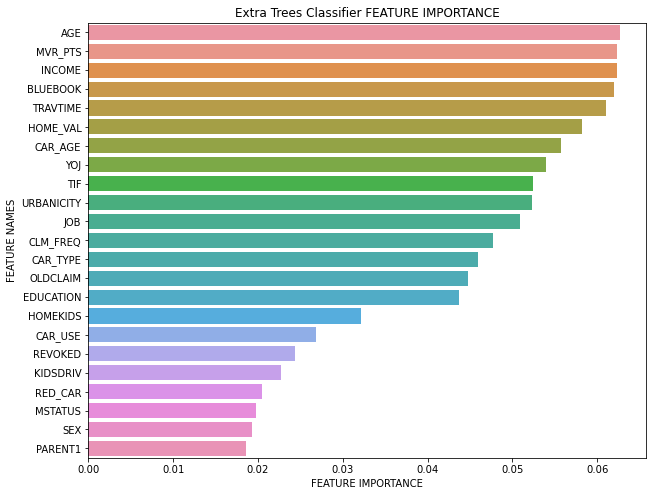

In [202]:
clf = ExtraTreesClassifier()
clf.fit(X_train,y_train)
plot_feature_importance(clf.feature_importances_,df_test.columns,'Extra Trees Classifier')

In [203]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

def score_classifier(dataset,classifier,labels):

    """
    performs 10 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    kf = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recalls = []
    for training_ids,test_ids in kf.split(dataset,labels):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)
        confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recalls.append(recall_score(test_labels, predicted_labels))
    #print(confusion_mat)
    return(recalls)

In [204]:
liste_recalls = []

for name, model in models:
    liste_recalls.append(score_classifier(X_train,model,y_train))

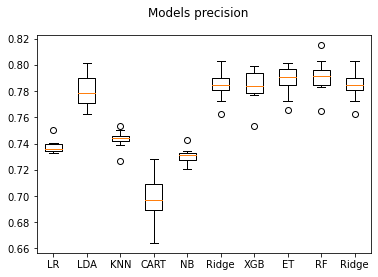

In [205]:
fig = plt.figure()
fig.suptitle('Models precision')
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(names)
plt.show()
plt.close()

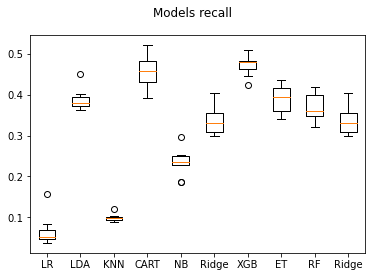

In [206]:
fig = plt.figure()
fig.suptitle('Models recall')
ax = fig.add_subplot(111)
plt.boxplot(liste_recalls)
ax.set_xticklabels(names)
plt.show()
plt.close()

We see that the best models have a precision of roughly 80% and a lower recall, between 0.4 et 0.5. We still need to do hyperparameter tuning and some transformations on the dataset (such as taking the logarithm of the amount columns) to get a satisfying precision and recall.

#### We can now make predictions and export them with the csv format.

In [207]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(df_test)
predictions[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0.])

In [208]:
df_test['TARGET_FLAG'] = predictions

In [147]:
prediction = pd.DataFrame(df_test).to_csv('prediction.csv')